# Logistische Regression
In diesem Notebook behandeln wir die logistische Regression, mit welcher wir die Stornierungen vorhersagen.
Actually: ... mit welcher wir die Wahrscheinlichkeit vorhersagen, mit welcher ein Filmdatensatz (k)eine Altersbewertung enthält.

## Load Packages

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')
import statsmodels.api as sm
import scipy.stats
import scipy.special
import sklearn.linear_model
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
#from pygam import LinearGAM, s, f
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
import feature_engine.imputation as imp
from feature_engine.encoding import OneHotEncoder

import matplotlib.pyplot as plt

## Load Data

In [62]:
X_train = pd.read_csv('Xtrain_tvshows_featured.csv')
X_test = pd.read_csv('Xtest_tvshows_featured.csv')
y_train = pd.read_csv('ytrain_tvshows.csv')
y_test = pd.read_csv('ytest_tvshows.csv')
print("Shape of X Train: {}".format(X_train.shape))
print("Shape of X Test: {}".format(X_test.shape))
print("Shape of y Train: {}".format(y_train.shape))
print("Shape of y Test: {}".format(y_test.shape))

Shape of X Train: (4294, 10)
Shape of X Test: (1074, 10)
Shape of y Train: (4294, 1)
Shape of y Test: (1074, 1)


## Beschreibung abrufen

In [63]:
X_train.describe()

,Year,IMDb,Rotten_Tomatoes,Year.1,IMDb.1,Rotten_Tomatoes.1,Netflix,Hulu,Prime Video,Disney+
count,4294.000000,4294.000000,4294.000000,4294.000000,4294.000000,4294.000000,4294.000000,4294.000000,4294.000000,4294.000000
mean,0.072168,0.705047,0.413937,10.443642,7.092897,47.254308,0.364462,0.300885,0.343735,0.065906
std,0.088740,0.129606,0.217222,10.382548,1.101651,19.550018,0.481335,0.458696,0.475009,0.248146
min,0.000000,0.000000,0.000000,2.000000,1.100000,10.000000,0.000000,0.000000,0.000000,0.000000
25%,0.025641,0.635294,0.288889,5.000000,6.500000,36.000000,0.000000,0.000000,0.000000,0.000000
50%,0.042735,0.729412,0.422222,7.000000,7.300000,48.000000,0.000000,0.000000,0.000000,0.000000
75%,0.085470,0.788235,0.555556,12.000000,7.800000,60.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,119.000000,9.600000,100.000000,1.000000,1.000000,1.000000,1.000000


In [64]:
X_train.head()

,Year,IMDb,Rotten_Tomatoes,Year.1,IMDb.1,Rotten_Tomatoes.1,Netflix,Hulu,Prime Video,Disney+
0,0.051282,0.600000,0.311111,8,6.2,38.0,0,0,1,0
1,0.282051,0.694118,0.700000,35,7.0,73.0,0,1,1,0
2,0.042735,0.717647,0.677778,7,7.2,71.0,1,0,0,0
3,0.034188,0.670588,0.000000,6,6.8,10.0,0,0,1,0
4,0.000000,0.576471,0.466667,2,6.0,52.0,0,1,0,0


## Selecting Feature (Tutorial: https://www.datacamp.com/tutorial/understanding-logistic-regression-python) unsicher obs stimmt... --> checce nöd wie die Target variable definiert wird ( label??) Also - where's unsere Age_na Column? :-/ --> Das wäre die Target Variable?

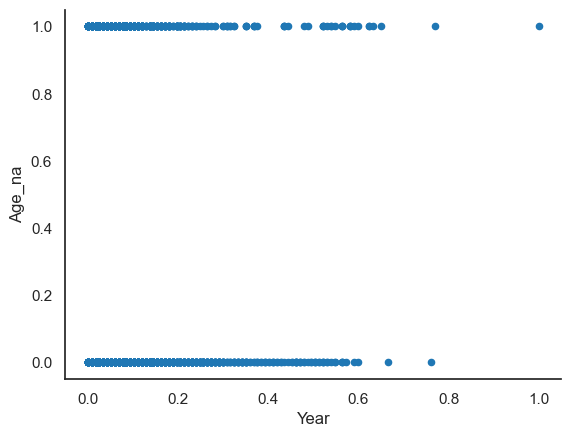

In [65]:
#split dataset in features and target variable
#feature_cols = ['Year', 'IMDb', 'Rotten_Tomatoes', 'Netflix','Hulu','Prime Video','Disney+']
#X = X_train[feature_cols] # Features
#y = y_train # Target variable

tabelle = X_train[['Year', 'IMDb', 'Rotten_Tomatoes', 'Netflix','Hulu','Prime Video','Disney+']]
tabelle = tabelle.join(y_train)
tabelle.head()
tabelle.plot.scatter('Year', 'Age_na')
sns.despine()

## Logistische Regression

In [66]:
logreg = LogisticRegression(penalty=None)
logreg.fit(X_train, y_train)

/Users/silyr/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/silyr/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(penalty=None)

In [67]:
#ke ahnig wasmer hie mache aber it's worth trying
logreg = sklearn.linear_model.LogisticRegression(C=1e12, random_state=0)
logreg.fit(tabelle['Year'].values.reshape(-1,1), tabelle['Age_na'])
print(logreg.intercept_, logreg.coef_)

[-0.24051924] [[-2.31928617]]


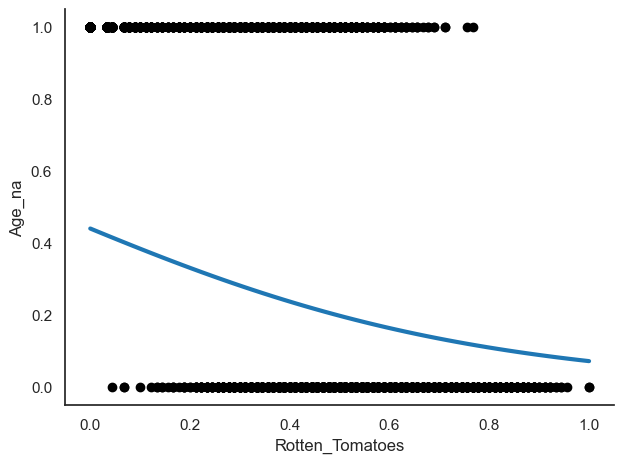

In [71]:
x = tabelle['Rotten_Tomatoes']
y = tabelle['Age_na']


def plot_log_reg(x, y, logreg, xmin=None, xmax=None, alpha=1, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.scatter(x, y, color='black', zorder=20, alpha=alpha)
    if xmin is None:
        xmin = x.min()
    if xmax is None:
        xmax = x.max()
    X_test = np.linspace(xmin, xmax)

    loss = scipy.special.expit(X_test * logreg.coef_ + logreg.intercept_).ravel()
    ax.plot(X_test, loss, linewidth=3)

    ax.set_xlabel('Rotten_Tomatoes')
    ax.set_ylabel('Age_na')
    fig.tight_layout()
    sns.despine()
    return fig, ax


plot_log_reg(x, y, logreg, xmin=0, xmax=1);

1## Model Development and Prediction (noch keine Ahnung ab hier) - eingefügt vom oben verlinkten Tutorial

In [40]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

/Users/silyr/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/silyr/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Logistic Regression from Statistics Packages - ab hier wieder Inhalte von Yves Staudt, nix dran gemacht.

In [41]:
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.391412
         Iterations 24
                                 Results: Logit
Model:                     Logit                 Pseudo R-squared:      0.419    
Dependent Variable:        Age_na                AIC:                   3381.4466
Date:                      2023-05-04 13:53      BIC:                   3445.0964
No. Observations:          4294                  Log-Likelihood:        -1680.7  
Df Model:                  9                     LL-Null:               -2891.3  
Df Residuals:              4284                  LLR p-value:           0.0000   
Converged:                 1.0000                Scale:                 1.0000   
No. Iterations:            24.0000                                               
---------------------------------------------------------------------------------
                   Coef.     Std.Err.      z    P>|z|      [0.025       0.975]   
-----------------------------

## Logistic Regression with Scikit Learn

In [42]:
logreg = LogisticRegression(penalty=None)
logreg.fit(X_train, y_train)

/Users/silyr/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/silyr/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(penalty=None)

## Prediction

Vorhersage der Gruppe.<

In [43]:
y_pred = logreg.predict(X_test)
y_pred

array([1, 0, 1, ..., 0, 0, 1])

Vorhersage der Wahrscheinlichkeit

In [44]:
y_pred_proba = logreg.predict_proba(X_test)
y_pred_proba

array([[0.01438238, 0.98561762],
       [0.8104239 , 0.1895761 ],
       [0.02131813, 0.97868187],
       ...,
       [0.603357  , 0.396643  ],
       [0.9013734 , 0.0986266 ],
       [0.02832729, 0.97167271]])

## Model Evaluation

### Confusion Matrix

In [45]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[568 100]
 [108 298]]


### Accuracy Score

In [46]:
metrics.accuracy_score(y_test, y_pred)

0.8063314711359404

### Precision and Recall

In [47]:
metrics.precision_score(y_test,y_pred)

0.7487437185929648

In [48]:
metrics.recall_score(y_test,y_pred)

0.7339901477832512

### F1-Score

In [49]:
metrics.f1_score(y_test, y_pred)

0.7412935323383084

### Area Under the Curve

In [50]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
metrics.auc(fpr, tpr)

0.7921447744904281